In [1]:
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
from matplotlib import pyplot as plt
import numpy as np
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['font.serif'] ="Cambria"
mpl.rcParams['font.family'] ="serif"
mpl.rcParams['font.size']="16"

# Variable name key

COMPONENTS: variable_component_position\
F = mol flow (mol.s-1)

etn = ethanol\
ace = acetaldehyde\
dee = diethyl ether\
hyd = hydrogen\
wat = water\
but = 1-butene\
etl = ethylene

i = inlet

OTHER:\
Dto = outside tube diameter\
Dti = inside tube diameter\
tt = tube thickness\
st = tube spacing (center to center)\
Nt = number of tubes

# Properties and constants

In [2]:
R = 8.314 # J.mol.K-1
σ = 5.67e-8 # W.m-2.K-4

## Kinetic constants

In [58]:
A_list = np.array([5.41e6/101325, 9.55e7/101325**2, 2.79e10/101325, 2.78e8/101325, 1.45e7/101325**2]) # mol.Pa-1.kg.-1.s-1 (1st order), mol.Pa-2.kg.-1.s-1 (2nd order) 
Ea_list = np.array([147.7, 101.0, 135.0, 138.4, 113.7])*1e3 # J.mol-1
A_list

array([5.33925487e+01, 9.30186745e-03, 2.75351591e+05, 2.74364668e+03,
       1.41232542e-03])

## Thermodynamic properties

### Heats of formation
Source: Perry 8th, Table 2-179\
Reference to 298.15 K

In [4]:
Hfm_etn = -23.495e7*1e-3 # J.mol-1
Hfm_ace = -16.64e7*1e-3 # J.mol-1
Hfm_dee = -25.21e7*1e-3 # J.mol-1
Hfm_hyd = 0*1e-3 # J.mol-1
Hfm_wat = -24.1814e7*1e-3 # J.mol-1
Hfm_co2 = -24.1814e7*1e-3 # J.mol-1
Hfm_but = -0.05e7*1e-3 # J.mol-1
Hfm_etl = 5.251e7*1e-3 # J.mol-1

### Heats of reaction
Calculated via Hess's law

In [5]:
ΔHrx1_ref = Hfm_etl + Hfm_wat - Hfm_etn
ΔHrx2_ref = Hfm_dee + Hfm_wat - 2*Hfm_etn
ΔHrx3_ref = 2*Hfm_etl + Hfm_wat - Hfm_dee
ΔHrx4_ref = Hfm_ace + Hfm_hyd - Hfm_etn
ΔHrx5_ref = Hfm_but - 2*Hfm_etl

ΔHrx_comb_ref = -0.80262e9*1e-3 # J.mol-1

ΔHrx_ref_list = [ΔHrx1_ref, ΔHrx2_ref, ΔHrx3_ref, ΔHrx4_ref, ΔHrx5_ref]

### Heat capacities
Source: Perry 8th, Table 2-156\
Trange = 200--1500 K\
Yaws

In [6]:
# Perry - hyperbolic
Cp_constants_etn = [0.492e5, 1.4577e5, 1.6628e3, 0.939e5, 744.7]
Cp_constants_ace = [0.4451e5, 1.0687e5, 1.6141e3, 0.6135e5, 737.8]
Cp_constants_dee = [0.8621e5, 2.551e5, 1.5413e3, 1.437e5, 688.9]
Cp_constants_hyd = [0.27617e5, 0.0956e5, 2.466e3, 0.0376e5, 567.6]
Cp_constants_wat = [0.33363e5, 0.2679e5, 2.6105e3, 0.08896e5, 1169]
Cp_constants_but = [0.64257e5, 2.0618e5, 1.6768e3, 1.3324e5, 757.06]
Cp_constants_etl = [0.3338e5, 0.9479e5, 1.596e3, 0.551e5, 740.8]

# Yaws - polynomial
Cp_constants_o2 = [29.7902399531962, -9.48853768266291e-3, 2.85799016034241e-05, 9.87286057866708e-09]
Cp_constants_n2 = [28.7167713794797, 7.34582726095694e-03, -4.54759070492041e-05, 1.16406082454094e-07]
Cp_constants_co2 = [23.5061038797879, 3.80655731822383e-02, 7.40233050458845e-05, -2.22713256071084e-07]
Cp_constants_h2o = [33.1743818702509, -3.24633355028777e-03, 1.74365275243944e-05, -5.97957584435752e-09]  

def Cp_component_fn(Cp_constants, T):
    C1, C2, C3, C4, C5 = Cp_constants
    return (C1 + C2*((C3/T)/(np.sinh(C3/T)))**2 + C4*((C5/T)/(np.cosh(C5/T)))**2)*1e-3 # J.mol.K-1
def Cp_all_fn(T):
    return [Cp_component_fn(Cp_constants, T) for Cp_constants in [Cp_constants_etn, Cp_constants_ace, Cp_constants_dee, Cp_constants_hyd, Cp_constants_wat, Cp_constants_but, Cp_constants_etl]]
def Cp_mix_fn(mol_fracs, T):
    Cp_list = Cp_all_fn(T)
    return sum(np.array(mol_fracs)*np.array(Cp_list))

In [7]:
def ΔCprx_all_fn(Cp_list):
    Cp_etn, Cp_ace, Cp_dee, Cp_hyd, Cp_wat, Cp_but, Cp_etl = Cp_list
    ΔCprx1 = Cp_wat + Cp_etl - Cp_etn
    ΔCprx2 = Cp_dee + Cp_wat - 2*Cp_etn
    ΔCprx3 = 2*Cp_etl + Cp_wat - Cp_dee
    ΔCprx4 = Cp_ace + Cp_hyd - Cp_etn
    ΔCprx5 = Cp_but - 2*Cp_etl
    return [ΔCprx1, ΔCprx2, ΔCprx3, ΔCprx4, ΔCprx5]
def ΔHrx_all_fn(ΔCprx_list, T):
    return np.array(ΔHrx_ref_list) + np.array(ΔCprx_list)*(T - 298.15)

## Physical properties

### Molar masses
Source: Perry 8th, Table 2-156

In [8]:
MM_etn = 46.068
MM_ace = 44.053
MM_dee = 74.122
MM_hyd = 2.016
MM_wat = 18.015
MM_but = 56.106
MM_etl = 28.053
MM_list = [MM_etn, MM_ace, MM_dee, MM_hyd, MM_wat, MM_but, MM_etl]

## Viscosities
Source: Perry 8th, Table 2-312

In [9]:
μ_constants_etn = [1.0613e-7, 0.8066, 52.7, 0]
μ_constants_ace = [1.222e-7, 0.787, 77, 0]
μ_constants_dee = [74.122, 1.948e-6, 0.41, 495.8]
#μ_constants_dee = [1.948e-6, 0.41, 495.8, 0]
μ_constants_hyd = [1.797e-7, 0.685, -0.59, 140]
μ_constants_wat = [1.7096e-8, 1.1146, 0, 0]
μ_constants_but = [6.9744e-7, 0.5462, 305.25, 0]
μ_constants_etl = [2.0789e-6, 0.4163, 352.7, 0]

def μ_component_fn(μ_constants, T):
    C1, C2, C3, C4 = μ_constants
    return C1*T**C2/(1 + C3/T + C4/T**2) # Pa.s

def μ_mix_fn(mol_fracs, T):
    μ_list = [μ_component_fn(μ_constants, T) for μ_constants in [μ_constants_etn, μ_constants_ace, μ_constants_dee, μ_constants_hyd, μ_constants_wat, μ_constants_but, μ_constants_etl]]
    μ_mix = 0
    for i in range(len(mol_fracs)):
        xjφij = 0
        for j in range(len(mol_fracs)):
            φij = (1 + (μ_list[i]/μ_list[j])**(1/2)*(MM_list[j]/MM_list[i])**(1/4))**(2)/(2*2**(1/2)*(1 + MM_list[i]/MM_list[j])**(1/2))
            xjφij += mol_fracs[j]*φij
        μ_mix += mol_fracs[i]*μ_list[i]/xjφij
    return μ_mix # Pa.s

## Thermal conductivities
Source: Perry 8th, Table 2-314

In [10]:
k_constants_etn = [-0.010109, 0.6475, -7332, -268000]
k_constants_ace = [3.7272e-7, 1.8129, 0, 0]
k_constants_dee = [-0.0044894, 0.6155, -3266.3, 0]
k_constants_hyd = [0.002653, 0.7452, 12, 0]
k_constants_wat = [6.2041e-6, 1.3973, 0, 0]
k_constants_but = [0.22153, -0.00035023, 0, 0]
k_constants_etl = [8.6806e-6, 1.4559, 299.72, -29403]

def k_component_fn(k_constants, T):
    C1 ,C2, C3, C4 = k_constants
    return C1*T**C2/(1 + C3/T + C4/T**2) # W.m-1.K-1

def k_mix_fn(mol_fracs, T):
    k_list = [k_component_fn(k_constants, T) for k_constants in [k_constants_etn, k_constants_ace, k_constants_dee, k_constants_hyd, k_constants_wat, k_constants_but, k_constants_etl]]
    μ_list = [μ_component_fn(μ_constants, T) for μ_constants in [μ_constants_etn, μ_constants_ace, μ_constants_dee, μ_constants_hyd, μ_constants_wat, μ_constants_but, μ_constants_etl]]
    k_mix = 0
    for i in range(len(mol_fracs)):
        xjφij = 0
        for j in range(len(mol_fracs)):
            φij = (1 + (μ_list[i]/μ_list[j])**(1/2)*(MM_list[j]/MM_list[i])**(1/4))**(2)/(2*2**(1/2)*(1 + MM_list[i]/MM_list[j])**(1/2))
            xjφij += mol_fracs[j]*φij
        k_mix += mol_fracs[i]*k_list[i]/xjφij
    return k_mix # W.m-1.K-1

## Density
Assumes ideal gasses and ideal vapour mixing

In [11]:
def ρ_mix_fn(mol_fracs, T, P):
    MM = sum([mol_fracs[i]*MM_list[i] for i in range(len(mol_fracs))])
    return P/(R*T)*MM*1e-3 # kg.m-3

## Furnace, reactor and catalyst properties
α Source: Perry Fig 5-15, page 5-23\
For two rows of tubes

In [12]:
F_rad = 0.65 # radiation exchange factor
α = 0.9
ρcat = 1136.4 # kg.m-3
φ = 0.4 # bed porosity
γ = 1 # shape factor for sphere

# Simulation

In [13]:
def solve_Tt_fn(Tt, *args):
    h, T = args
    return σ*α*F_rad*(Tg**4 - Tt**4)*dAcpdw - h*(Tt - T)*dAt_sa_total_dw

def pbr_fn(w, var):    
    F_etn, F_ace, F_dee, F_hyd, F_wat, F_but, F_etl, P, T = var
    F_list = var[0:7]
    F_total = sum(F_list)
    mol_fracs = np.array(F_list)/F_total
    P_etn, P_dee, P_etl = (np.array([F_etn, F_dee, F_etl])/F_total)*P

    μ_mix = μ_mix_fn(mol_fracs, T)
    ρ_mix = ρ_mix_fn(mol_fracs, T, P)
    k_mix = k_mix_fn(mol_fracs, T)
    Cp_mix = Cp_mix_fn(mol_fracs, T)
    Pr = μ_mix*Cp_mix/k_mix
    
    # kinetics and reaction    
    k_list = A_list*np.exp(-Ea_list/(R*T))
    r1 = k_list[1 - 1]*P_etn
    r2 = k_list[2 - 1]*P_etn**2
    r3 = k_list[3 - 1]*P_dee
    r4 = k_list[4 - 1]*P_etn
    r5 = k_list[5 - 1]*P_etl**2
    dF_etn_dw = -r1 - 2*r2 - r4
    dF_ace_dw = r4
    dF_dee_dw = r2 - r3
    dF_hyd_dw = r4
    dF_wat_dw = r1 + r2 + r3
    dF_but_dw = r5
    dF_etl_dw = r1 + 2*r3 - 2*r5

    # pressure
    K = G/(ρi*Dp)*(1-φ)/φ**3*(150*μ_mix*(1 - φ)/Dp + 1.75*G)
    dPdz = -K*(Pi/P)*(F_total/F_total_i)*(T/Ti)
    dPdw = dPdz/(At_cs_total*ρbed)

    # temperature
    #Gnielinski correlation
    Q = F_total*R*T/P # [m3.s-1]
    v = Q/At_cs_total # [m.s-1] superficial velocity
    Re = ρ_mix*v*Dp/(μ_mix*φ)
    Nu_lam = 0.664*Re**(1/2)*Pr**(1/3)
    Nu_turb = 0.037*Re**0.8*Pr/(1 + 2.443*Re**(-0.1)*(Pr**(2/3) - 1))
    Nu_single_sphere = 2 + (Nu_lam**2 + Nu_turb**2)**(1/2)
    Nu = f_φ*Nu_single_sphere
    h = Nu*k_mix/Dp # heat transfer coefficient inside the packed bed

    Tt = fsolve(solve_Tt_fn, np.mean([T, Tg]), args=(h, T))[0]
    dQdw = h*(Tt - T)*dAt_sa_total_dw
    Cp_list = Cp_all_fn(T)
    ΔCprx_list = ΔCprx_all_fn(Cp_list)
    ΔHrx_list = ΔHrx_all_fn(ΔCprx_list, T)
    dεdw_list = [r1, r2, r3, r4, r5]
    dTdw = (dQdw - sum(np.array(dεdw_list)*np.array(ΔHrx_list)))/sum((np.array(F_list)*np.array(Cp_list)))
    
    return [dF_etn_dw, dF_ace_dw, dF_dee_dw, dF_hyd_dw, dF_wat_dw, dF_but_dw, dF_etl_dw, dPdw, dTdw]

def pbr_fn_with_MT(w, var):    
    F_etn, F_ace, F_dee, F_hyd, F_wat, F_but, F_etl, P, T = var
    F_list = var[0:7]
    F_total = sum(F_list)
    Q = F_total*R*T/P # [m3.s-1]
    v = Q/At_cs_total # [m.s-1] superficial velocity
    mol_fracs = np.array(F_list)/F_total
    P_etn, P_dee, P_etl = (np.array([F_etn, F_dee, F_etl])/F_total)*P
    
    μ_mix = μ_mix_fn(mol_fracs, T)
    ρ_mix = ρ_mix_fn(mol_fracs, T, P)
    k_mix = k_mix_fn(mol_fracs, T)
    Cp_mix = Cp_mix_fn(mol_fracs, T)
    Pr = μ_mix*Cp_mix/k_mix
    
    # kinetics and reaction    
    k_list = A_list*np.exp(-Ea_list/(R*T))

    #rxn 2 - done
    rhs = (v*Dp*ρ_mix/(μ_mix*(1 - φ)*γ))**(1/2)*(μ_mix/(ρ_mix*D_ab_etn))**(1/3) # Theones-Kramer
    kc_2 = rhs*γ*D_ab_etn*(1 - φ)/(φ*Dp)
    a = k_list[2 - 1]
    b = kc_2*am/(2*R*T)
    c = -kc_2*am/(2*R*T)*P_etn
    P_etn_s = (-b + np.sqrt(b**2 - 4*a*c))/(2*a) # surface partial pressure
    C_etn_s =  P_etn_s/(R*T) # surface concentration
    
    TM_2 = ((2*k_list[2 - 1]*(R*T)**2*ρcat*C_etn_s*(Dp/2)**2)/De_etn)**(1/2) # thiele modulus
    
    if (TM_2 <= 40): # use the plot estimation
        log_TM_2 = np.log10(TM_2)
        η_2 = 10**(0.1293*log_TM_2**4 - 0.1729*log_TM_2**3 - 0.38*log_TM_2**2 - 0.192*log_TM_2 - 0.0495)
        if (η_2 > 1):
            η_2 = 1
    else:
        η_2 = (2/3)**(1/2)*3/TM_2 # diffusion limited regime
    
    #rxn 3 - done
    TM_3 = ((k_list[3 - 1]*R*T*ρcat*(Dp/2)**2)/De_dee)**(1/2) # thiele modulus
    η_3 = 3/TM_3**2*(TM_3/np.tanh(TM_3) - 1)
    rhs = (v*Dp*ρ_mix/(μ_mix*(1 - φ)*γ))**(1/2)*(μ_mix/(ρ_mix*D_ab_dee))**(1/3) # Theones-Kramer
    kc_3 = rhs*γ*D_ab_dee*(1 - φ)/(φ*Dp)
    keff_3 = ((kc_3*am/(R*T))**(-1) + (η_3*k_list[3 - 1])**(-1))**(-1)

    r1 = k_list[1 - 1]*P_etn
    r2 = η_2*k_list[2 - 1]*P_etn_s**2
    r3 = keff_3*P_dee
    r4 = k_list[4 - 1]*P_etn
    r5 = k_list[5 - 1]*P_etl**2

    dF_etn_dw = -r1 - 2*r2 - r4
    dF_ace_dw = r4
    dF_dee_dw = r2 - r3
    dF_hyd_dw = r4
    dF_wat_dw = r1 + r2 + r3
    dF_but_dw = r5
    dF_etl_dw = r1 + 2*r3 - 2*r5

    # pressure
    K = G/(ρi*Dp)*(1-φ)/φ**3*(150*μ_mix*(1 - φ)/Dp + 1.75*G)
    dPdz = -K*(Pi/P)*(F_total/F_total_i)*(T/Ti)
    dPdw = dPdz/(At_cs_total*ρbed)

    # temperature
    #Gnielinski correlation
    Re = ρ_mix*v*Dp/(μ_mix*φ)
    Nu_lam = 0.664*Re**(1/2)*Pr**(1/3)
    Nu_turb = 0.037*Re**0.8*Pr/(1 + 2.443*Re**(-0.1)*(Pr**(2/3) - 1))
    Nu_single_sphere = 2 + (Nu_lam**2 + Nu_turb**2)**(1/2)
    Nu = f_φ*Nu_single_sphere
    h = Nu*k_mix/Dp # heat transfer coefficient inside the packed bed

    Tt = fsolve(solve_Tt_fn, Tg, args=(h, T))[0]
    dQdw = h*(Tt - T)*dAt_sa_total_dw
    Cp_list = Cp_all_fn(T)
    ΔCprx_list = ΔCprx_all_fn(Cp_list)
    ΔHrx_list = ΔHrx_all_fn(ΔCprx_list, T)
    dεdw_list = [r1, r2, r3, r4, r5]
    dTdw = (dQdw - sum(np.array(dεdw_list)*np.array(ΔHrx_list)))/sum((np.array(F_list)*np.array(Cp_list)))
    
    return [dF_etn_dw, dF_ace_dw, dF_dee_dw, dF_hyd_dw, dF_wat_dw, dF_but_dw, dF_etl_dw, dPdw, dTdw]

def supporting_calcs_fn():
    M_total_i = F_etn_i*MM_etn*1e-3 + F_wat_i*MM_wat*1e-3 # [kg.s-1]
    Dti = Dto - 2*tt
    At_cs_total = np.pi/4*Dti**2*Nt # total internal cross sectional tube area
    G = M_total_i/At_cs_total
    F_total_i = sum([F_etn_i, F_wat_i])
    ρi = ρ_mix_fn([F_etn_i/F_total_i, 0, 0, 0, F_wat_i/F_total_i, 0, 0], Ti, Pi)
    ρbed = ρcat*(1 - φ)
    f_φ = 1 + 1.5*(1 - φ) # shape factor (for packed bed Nusselt corr.)
    #dAcpdw = 2*Nt*st/(At_cs_total*ρbed)
    dAcpdw = Nt*st/(At_cs_total*ρbed)
    dAt_sa_total_dw = Nt*np.pi*Dti/(At_cs_total*ρbed)
    w_span = np.linspace(0, w_end, 2000)
    am = 6/(Dp*ρcat)
    
    return M_total_i, Dti, At_cs_total, G, F_total_i, ρi, ρbed, f_φ, α, dAcpdw, dAt_sa_total_dw, w_span, am

def calc_kc(*args):
    v = args

def calc_MT(v, ρ_mix, μ_mix, D_ab, De, C, r, n):    
    rhs = (v*Dp*ρ_mix/(μ_mix*(1 - φ)*γ))**(1/2)*(μ_mix/(ρ_mix*D_ab))**(1/3) # Theones-Kramer
    kc = rhs*γ*D_ab*(1 - φ)/(φ*Dp)
    
    mears = r*ρbed*(Dp/2)*n/(kc*C)      
    Cwp = r*ρcat*(Dp/2)**2/(De*C)
    return mears, Cwp 
    
def pbr_mt_var_fn(var): # run after initial simulation performed to check MT effects  
    mears_1_list, Cwp_1_list, mears_2_list, Cwp_2_list, mears_3_list, Cwp_3_list, mears_4_list, Cwp_4_list, mears_5_list, Cwp_5_list  = [], [], [], [], [], [], [], [], [], []
    var_matrix = np.array(var).T
    for var in var_matrix:
        F_etn, F_ace, F_dee, F_hyd, F_wat, F_but, F_etl, P, T = var
            
        F_list = var[0:7]
        F_total = sum(F_list)
        mol_fracs = np.array(F_list)/F_total
        P_etn, P_dee, P_etl = (np.array([F_etn, F_dee, F_etl])/F_total)*P
        
        # kinetics and reaction
        k_list = A_list*np.exp(-Ea_list/(R*T))
        r1 = k_list[1 - 1]*P_etn
        r2 = k_list[2 - 1]*P_etn**2
        r3 = k_list[3 - 1]*P_dee
        r4 = k_list[4 - 1]*P_etn
        r5 = k_list[5 - 1]*P_etl**2
        
        dF_etn_dw = -r1 - 2*r2 - r4
        dF_ace_dw = r4
        dF_dee_dw = r2 - r3
        dF_hyd_dw = r4
        dF_wat_dw = r1 + r2 + r3
        dF_but_dw = r5
        dF_etl_dw = r1 + 2*r3 - 2*r5
       
        ρ_mix = ρ_mix_fn(mol_fracs, T, P)
        μ_mix = μ_mix_fn(mol_fracs, T)
    
        Q = F_total*R*T/P # [m3.s-1]
        v = Q/At_cs_total # [m.s-1] superficial velocity        

        C_etn = F_etn/Q # mol.m-3
        C_dee = F_dee/Q # mol.m-3
        C_etl = F_etl/Q # mol.m-3
        mears_1, Cwp_1 = calc_MT(v, ρ_mix, μ_mix, D_ab_etn, De_etn, C_etn, r1, 1)
        mears_2, Cwp_2 = calc_MT(v, ρ_mix, μ_mix, D_ab_etn, De_etn, C_etn, 2*r2, 2)
        mears_3, Cwp_3 = calc_MT(v, ρ_mix, μ_mix, D_ab_dee, De_dee, C_dee, r3, 1)
        mears_4, Cwp_4 = calc_MT(v, ρ_mix, μ_mix, D_ab_etn, De_etn, C_etn, 4, 1)
        mears_5, Cwp_5 = calc_MT(v, ρ_mix, μ_mix, D_ab_etl, De_etl, C_etl, 2*r5, 2)
        mears_1_list.append(mears_1)
        mears_2_list.append(mears_2)
        mears_3_list.append(mears_3)
        mears_4_list.append(mears_4)
        mears_5_list.append(mears_5)
        Cwp_1_list.append(Cwp_1)
        Cwp_2_list.append(Cwp_2)
        Cwp_3_list.append(Cwp_3)
        Cwp_4_list.append(Cwp_4)
        Cwp_5_list.append(Cwp_5)       

    return mears_1_list, Cwp_1_list, mears_2_list, Cwp_2_list, mears_3_list, Cwp_3_list, mears_4_list, Cwp_4_list, mears_5_list, Cwp_5_list

def calc_dimensions_fn():
    L = w/(ρbed*At_cs_total)
    D_bundle = Nt*st/np.pi
    return L, D_bundle, L/D_bundle

In [14]:
def simulate():
    sol = solve_ivp(pbr_fn, (0, w_end), [F_etn_i, 0, 0, 0, F_wat_i, 0, 0, Pi, Ti], dense_output=True)  
    F_etn, F_ace, F_dee, F_hyd, F_wat, F_but, F_etl, P, T = sol.sol(w_span)  
    
    return F_etn, F_ace, F_dee, F_hyd, F_wat, F_but, F_etl, P, T

def simulate_with_MT():
    sol = solve_ivp(pbr_fn_with_MT, (0, w_end), [F_etn_i, 0, 0, 0, F_wat_i, 0, 0, Pi, Ti], dense_output=True)  
    F_etn, F_ace, F_dee, F_hyd, F_wat, F_but, F_etl, P, T = sol.sol(w_span)  
    
    return F_etn, F_ace, F_dee, F_hyd, F_wat, F_but, F_etl, P, T

# Plotting

In [15]:
def plot_FTP():
    w_round = round(w, 2)
    plt.figure(dpi=100, figsize=(10, 5))
    plt.plot(w_span, F_etn, label='etn')
    plt.plot(w_span, F_ace, label='ace')
    plt.plot(w_span, F_dee, label='dee')
    plt.plot(w_span, F_hyd, label='hyd')
    plt.plot(w_span, F_wat, label='wat')
    plt.plot(w_span, F_but, label='but')
    plt.plot(w_span, F_etl, label='etl')
    plt.ylim(ymin=0)
    plt.xlim(0, w_end)
    plt.axvline(w, color='k', linestyle='dashed')
    plt.text(1.01*w, 0.5, f"Catalyst mass:{w_round} kg", rotation=90, verticalalignment='center')
    plt.xlabel('w [kg]')
    plt.ylabel('F [$mol.s^{-1}$]')
    plt.legend(loc='upper left')
    plt.tick_params(direction='in')
    #plt.savefig('final_F.png', bbox_inches='tight')
    
    plt.figure(dpi=100, figsize=(5, 5))
    plt.plot(w_span, T)
    plt.xlim(0, w_end)
    plt.axvline(w_round, color='k', linestyle='dashed')
    plt.xlabel('w [kg]')
    plt.ylabel('T [K]')
    plt.tick_params(direction='in')
    #plt.savefig('final_T.png', bbox_inches='tight')
    
    plt.figure(dpi=100, figsize=(5, 5))
    plt.plot(w_span, P*1e-5)
    plt.xlim(0, w_end)
    plt.axvline(w_round, color='k', linestyle='dashed')
    plt.xlabel('w [kg]')
    plt.ylabel('P [bar]')
    plt.tick_params(direction='in')
    #plt.savefig('final_P.png', bbox_inches='tight')
def plot_MT():
    plt.figure(dpi=100, figsize=(5, 5))
    plt.plot(w_span, mears_1, label='rxn 1')
    plt.plot(w_span, mears_2, label='rxn 2')
    plt.plot(w_span, mears_3, label='rxn 3')
    plt.plot(w_span, mears_4, label='rxn 4')
    plt.plot(w_span, mears_5, label='rxn 5')
    plt.ylim(0, 0.5)
    plt.xlim(0, w_end)
    plt.hlines(0.15, 0, w_end, 'r', linestyle='dashed')
    plt.axvline(w, color='k', linestyle='dashed')
    plt.legend(loc='upper left')
    plt.xlabel('w [kg]')
    plt.ylabel('Mears criterion number')
    plt.tick_params(direction='in')
    #plt.savefig('base_case_mears.png', bbox_inches='tight')
    
    plt.figure(dpi=100, figsize=(5, 5))
    plt.plot(w_span, Cwp_1, label='rxn 1')
    plt.plot(w_span, Cwp_2, label='rxn 2')
    plt.plot(w_span, Cwp_3, label='rxn 3')
    plt.plot(w_span, Cwp_4, label='rxn 4')
    plt.plot(w_span, Cwp_5, label='rxn 5')
    plt.ylim(0, 40)
    plt.xlim(0, w_end)
    plt.hlines(1, 0, w_end, 'r', linestyle='dashed')
    plt.axvline(w, color='k', linestyle='dashed')
    plt.legend(loc='upper left')
    plt.xlabel('w [kg]')
    plt.ylabel('Cwp')
    plt.tick_params(direction='in')
    #plt.savefig('base_case_wp.png', bbox_inches='tight')
    
def plot_P_drop():
    plt.figure(dpi=100, figsize=(10, 5))
    plt.plot(Dtos*1e3, P_drops, 'rx')
    plt.xlim(48.3 - 1, 101.6 + 20)
    plt.ylim(ymin=0)
    for i in range(len(P_drops)):
        if (i == 3):
            plt.text(Dtos[i]*1e3 + 1, P_drops[i] - 0.02, f"Nt = {Nts[i]}, w = {round(ws[i], 2)} kg", verticalalignment='center')
        else:
            plt.text(Dtos[i]*1e3 + 1, P_drops[i], f"Nt = {Nts[i]}, w = {round(ws[i], 2)} kg", verticalalignment='center')
    plt.xlabel('Dto [mm]')
    plt.ylabel('P drop [bar]')
    plt.tick_params(direction='in')
    #plt.savefig('Dto_opt', bbox_inches='tight')
    
def plot_Tg_opt():
    plt.figure(dpi=100, figsize=(10, 5))
    plt.plot(Tgs - 273.15, ws, 'rx')
    plt.xlim(Tgs[0] - 273.15 - 50, Tgs[-1] - 273.15 + 150)
    for i in range(len(Tgs)):
        text = '$S_{etl}$ = ' + str(round(S_etls[i], 2)) + ', $x_{etn}$ = ' + str(round(x_etns[i], 2)) + ' %'
        plt.text(Tgs[i] - 273.15 + 10, ws[i], text, verticalalignment='center')
    plt.xlabel('Tg [C]')
    plt.ylabel('Catalyst mass at max ethylene output [kg]')
    plt.tick_params(direction='in')
    #plt.savefig('Tg_opt.png', bbox_inches='tight')
    
def plot_Ti_opt():
    plt.figure(dpi=100, figsize=(10, 5))
    plt.plot(Tis - 273.15, ws, 'rx')
    plt.xlim(Tis[0] - 273.15 - 50, Tis[-1] - 273.15 + 400)
    for i in range(len(Tis)):
        text = '$S_{etl}$ = ' + str(round(S_etls[i], 2)) + ', $x_{etn}$ = ' + str(round(x_etns[i], 2)) + ' %'
        plt.text(Tis[i] - 273.15 + 10, ws[i], text, verticalalignment='center')
    plt.xlabel('Ti [C]')
    plt.ylabel('Catalyst mass at max ethylene output [kg]')
    plt.tick_params(direction='in')
    #plt.savefig('Ti_opt.png', bbox_inches='tight')

def plot_Pi_opt():
    plt.figure(dpi=100, figsize=(10, 5))
    plt.plot(Pis*1e-5, ws, 'rx')
    plt.xlim(Pis[0]*1e-5 - 1, Pis[-1]*1e-5 + 4)
    for i in range(len(Pis)):
        text = '$S_{etl}$ = ' + str(round(S_etls[i], 2)) + ', $x_{etn}$ = ' + str(round(x_etns[i], 2)) + ' %'
        plt.text(Pis[i]*1e-5 + 0.1, ws[i], text, verticalalignment='center')
    plt.xlabel('Pi [bar]')
    plt.ylabel('Catalyst mass at max ethylene output [kg]')
    plt.tick_params(direction='in')
    #plt.savefig('Pi_opt.png', bbox_inches='tight')
    
def plot_Dp_opt_mears():
    plt.figure(dpi=100, figsize=(5, 5))
    plt.plot(Dps*1e3, mears_avgs_1, 'x', label='rxn 1')
    plt.plot(Dps*1e3, mears_avgs_2, 'x', label='rxn 2')
    plt.plot(Dps*1e3, mears_avgs_3, 'x', label='rxn 3')
    plt.plot(Dps*1e3, mears_avgs_4, 'x', label='rxn 4')
    plt.plot(Dps*1e3, mears_avgs_5, 'x', label='rxn 5')
    plt.xlim(xmax=Dps[-1]*1e3 + 1)
    for i in range(len(Dps)):
        text = 'ΔP = ' + str(round(P_drops[i], 2)) + ' bar'
        plt.text(Dps[i]*1e3 + 0.1, 1.7, text, rotation=70,verticalalignment='center', fontsize='small')
    plt.legend()
    plt.xlabel('Dp [mm]')
    plt.ylabel('Mears criteria')
    plt.tick_params(direction='in')
    #plt.savefig('Dp_mears_opt.png', bbox_inches='tight')
    
def plot_Dp_opt_Cwp():
    plt.figure(dpi=100, figsize=(5, 5))
    plt.plot(Dps*1e3, Cwp_avgs_1, 'x', label='rxn 1')
    plt.plot(Dps*1e3, Cwp_avgs_2, 'x', label='rxn 2')
    plt.plot(Dps*1e3, Cwp_avgs_3, 'x', label='rxn 3')
    plt.plot(Dps*1e3, Cwp_avgs_4, 'x', label='rxn 4')
    plt.plot(Dps*1e3, Cwp_avgs_5, 'x', label='rxn 5')
    plt.xlim(xmax=Dps[-1]*1e3 + 1)
#     for i in range(len(Dps)):
#         text = 'P drop = ' + str(round(P_drops[i], 2)) + ' bar'
#         plt.text(Dps[i]*1e3 + 0.1, 550, text, rotation=90,verticalalignment='center')
    plt.legend()
    plt.xlabel('Dp [mm]')
    plt.ylabel('Cwp')
    plt.tick_params(direction='in')
    #plt.savefig('Dp_wp_opt.png', bbox_inches='tight')

# Base case

In [59]:
# revert to base case
F_etn_i = 3.2588907*1e3/3600 # mol.s-1
F_wat_i = 0.17152056*1e3/3600 # mol.s-1
Ti = 420 + 273.15 # K
Pi = 1.3*1e5 # Pa
Tg = 1000 + 273.15 # K
Dto = 0.0603 # m
tt = 0.002 # m
st = 2*Dto # m 
Nt = 7 # tubes
Dp = 5*1e-3 # m

w_end = 10# kg
F_etn_i, F_wat_i

(0.9052474166666666, 0.047644599999999995)

0.7532760835340587


(None, 1.0075737543065837)

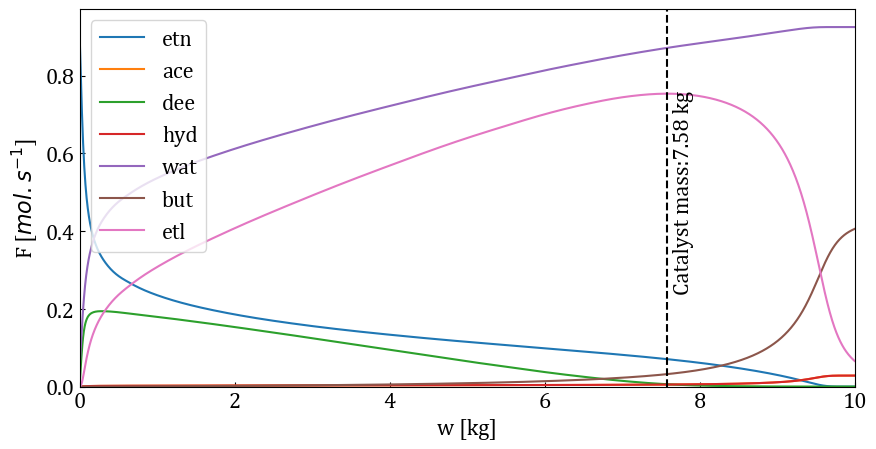

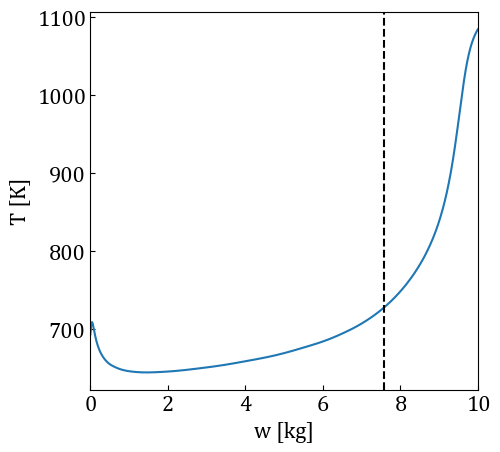

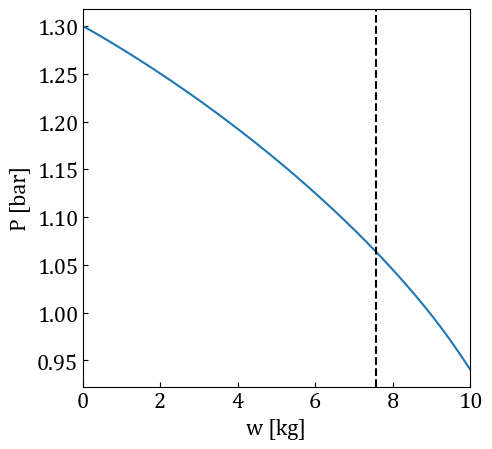

In [60]:
M_total_i, Dti, At_cs_total, G, F_total_i, ρi, ρbed, f_φ, α, dAcpdw, dAt_sa_total_dw, w_span, am = supporting_calcs_fn()
F_etn, F_ace, F_dee, F_hyd, F_wat, F_but, F_etl, P, T = var = simulate()
i_end = np.where(F_etl == max(F_etl))[0][0]
w = w_span[i_end]
print(F_etl[i_end])
plot_FTP()

## Dimentions

In [18]:
L, D_bundle, L_over_D_bundle = calc_dimensions_fn()
L, D_bundle, L_over_D_bundle

(0.638262340830253, 0.26871720591635606, 2.3752194752610136)

## MHSV

In [19]:
mhsv = M_total_i*3600/w
mhsv

20.20368197838681

## Mass balance

## Mass transfer effects

### Calculation of Dab
Equations from Welty p409, Hirschfelder et al correlation
data from Welty and https://link.springer.com/content/pdf/bbm%3A978-1-4757-1696-2%2F1.pdf

In [20]:
κ = 1.38e-16 #ergs.K-1
N = 6.022e23 # molecules.mol-1

σ_etn = 4.455 # Angstroms
σ_wat = 2.649 # Angstroms
σ_etl = 4.232 # Angstroms
σ_dee = 5.678 # Angstroms

ε_etn = κ*391
ε_wat = κ*356
ε_etl = κ*205
ε_dee = κ*313.8

T_avg = np.mean(T) # K
P_avg = np.mean(P)/101325 # atm

In [21]:
# Ethanol:

In [22]:
σ_eth_wat = (σ_etn + σ_wat)/2
ε_etn_wat = (ε_etn*ε_wat)**(1/2)

σ_eth_etl = (σ_etn + σ_etl)/2
ε_etn_etl = (ε_etn*ε_etl)**(1/2)

κ*T_avg/ε_etn_wat, κ*T_avg/ε_etn_etl

(1.9092816583904548, 2.516043057310785)

In [23]:
Ω_eth_wat = 1.105 # from Table K.1
Ω_eth_etl = 0.9996 # from Table K.1
D_etn_wat = 0.001858*T_avg**(3/2)*(1/MM_etn + 1/MM_wat)**(1/2)/(P_avg*σ_eth_wat**2*Ω_eth_wat)*1e-4 # m2.s-1
D_etn_etl = 0.001858*T_avg**(3/2)*(1/MM_etn + 1/MM_etl)**(1/2)/(P_avg*σ_eth_etl**2*Ω_eth_etl)*1e-4 # m2.s-1
D_etn_wat, D_etn_etl

(6.21378798803186e-05, 3.958999248150749e-05)

In [24]:
D_ab_etn = D_etn_etl # since D_etn_etl the smallest

In [25]:
# DEE

In [26]:
σ_dee_wat = (σ_dee + σ_wat)/2
ε_dee_wat = (ε_dee*ε_wat)**(1/2)

σ_dee_etl = (σ_dee + σ_etl)/2
ε_dee_etl = (ε_dee*ε_etl)**(1/2)

κ*T_avg/ε_dee_wat, κ*T_avg/ε_dee_etl

(2.131237796555068, 2.808535889891269)

In [27]:
Ω_dee_wat = 1.066 # from Table K.1
Ω_dee_etl = 0.9770 # from Table K.1
D_dee_wat = 0.001858*T_avg**(3/2)*(1/MM_dee + 1/MM_wat)**(1/2)/(P_avg*σ_dee_wat**2*Ω_dee_wat)*1e-4 # m2.s-1
D_dee_etl = 0.001858*T_avg**(3/2)*(1/MM_dee + 1/MM_etl)**(1/2)/(P_avg*σ_dee_etl**2*Ω_dee_etl)*1e-4 # m2.s-1
D_dee_wat, D_dee_etl

(4.4316148767724296e-05, 2.8809600750576504e-05)

In [28]:
D_ab_dee = D_dee_etl # since D_dee_etl the smallest

In [29]:
# Ethylene
σ_etl_wat = (σ_etl + σ_wat)/2
ε_etl_wat = (ε_etl*ε_wat)**(1/2)
κ*T_avg/ε_etl_wat

2.6368258563871145

In [30]:
Ω_etl_wat = 0.9937 # from Table K.1
D_etl_wat = 0.001858*T_avg**(3/2)*(1/MM_etl + 1/MM_wat)**(1/2)/(P_avg*σ_etl_wat**2*Ω_etl_wat)*1e-4 # m2.s-1
D_etl_wat

8.002109578893008e-05

In [31]:
D_ab_etl = D_etl_wat

### EMT and IMT

In [32]:
De_etn = D_ab_etn*0.4*0.8/3 # m2.s-1
De_dee = D_ab_dee*0.4*0.8/3 # m2.s-1
De_etl = D_ab_etl*0.4*0.8/3 # m2.s-1
De_etn, De_dee, De_etl

(4.2229325313608e-06, 3.0730240800614943e-06, 8.535583550819209e-06)

<ipython-input-13-8909204c3406>:165: RuntimeWarning: invalid value encountered in double_scalars
  mears = r*ρbed*(Dp/2)*n/(kc*C)
<ipython-input-13-8909204c3406>:166: RuntimeWarning: invalid value encountered in double_scalars
  Cwp = r*ρcat*(Dp/2)**2/(De*C)


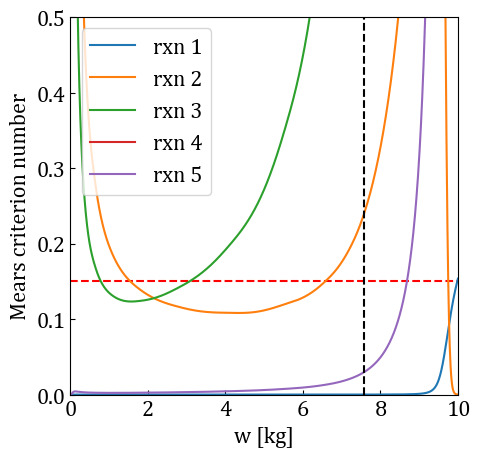

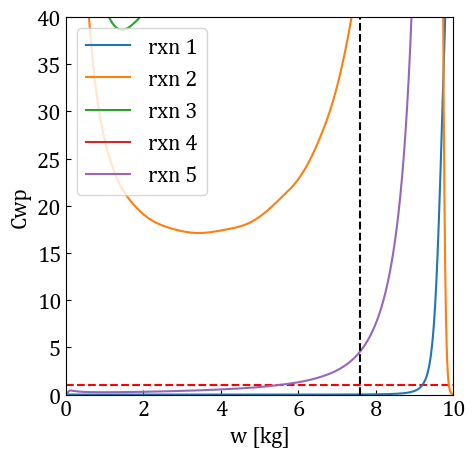

In [33]:
mears_1, Cwp_1, mears_2, Cwp_2, mears_3, Cwp_3, mears_4, Cwp_4, mears_5, Cwp_5  = pbr_mt_var_fn(var)
plot_MT()

# Base case with mass transfer limitations taken into account

1.8242775826493145 82.93994786258787 22.34046818324902 0.19681792346794058
0.4619889522018374
0.5772148214236655 0.26871720591635606 2.148038192996603


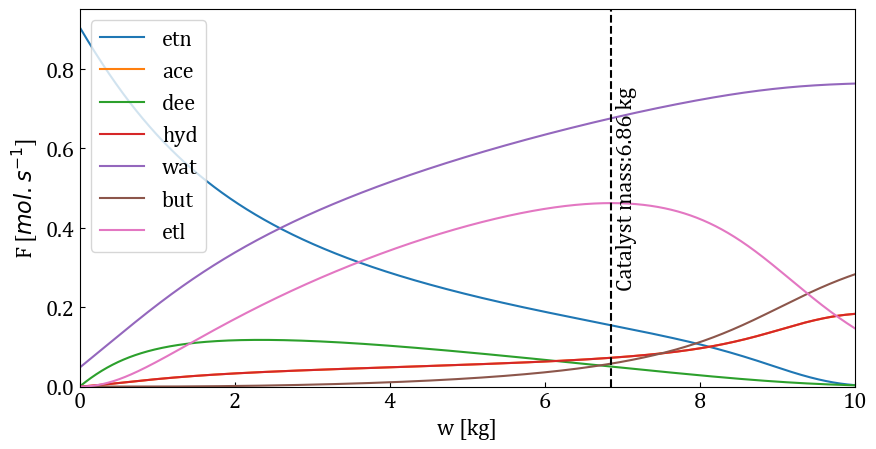

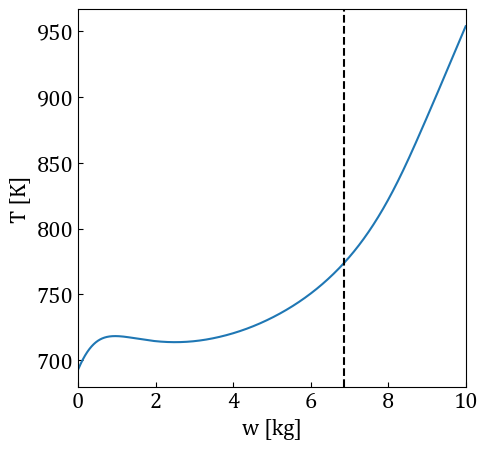

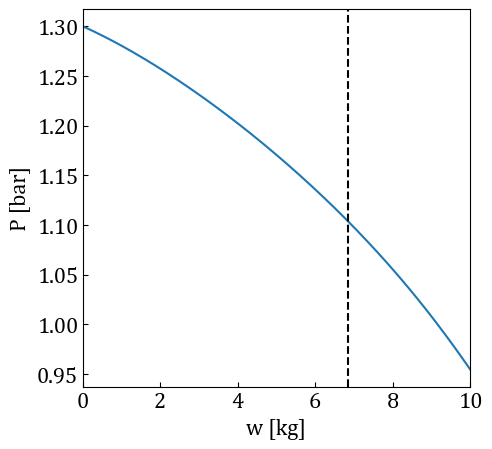

In [34]:
M_total_i, Dti, At_cs_total, G, F_total_i, ρi, ρbed, f_φ, α, dAcpdw, dAt_sa_total_dw, w_span, am = supporting_calcs_fn()
F_etn, F_ace, F_dee, F_hyd, F_wat, F_but, F_etl, P, T = var = simulate_with_MT()
i_end = np.where(F_etl == max(F_etl))[0][0]
w = w_span[i_end]

F_etn_end, F_ace_end, F_dee_end, F_hyd_end, F_wat_end, F_but_end, F_etl_end = F_etn[i_end], F_ace[i_end], F_dee[i_end], F_hyd[i_end], F_wat[i_end], F_but[i_end], F_etl[i_end]
F_total_end = sum([F_etn_end, F_ace_end, F_dee_end, F_hyd_end, F_wat_end, F_but_end, F_etl_end])
S_etl = F_etl_end/sum([F_ace_end, F_dee_end, F_hyd_end, F_but_end])
x_etn = (F_etn_i - F_etn_end)/F_etn_i*100
mhsv = M_total_i*3600/w
P_end = P[i_end]
P_drop = 1.3 - P_end*1e-5 # bar
L, D_bundle, L_over_D_bundle = calc_dimensions_fn()
print(S_etl, x_etn, mhsv, P_drop)
print(F_etl[i_end])
print(L, D_bundle, L_over_D_bundle)
plot_FTP()

In [35]:
F_list_end = np.array([F_etn[i_end], F_ace[i_end], F_dee[i_end], F_hyd[i_end], F_wat[i_end], F_but[i_end], F_etl[i_end]])
M_total_out = sum(F_list_end*np.array([MM_etn, MM_ace, MM_dee, MM_hyd, MM_wat, MM_but, MM_etl]))*1e-3
M_total_i, M_total_out, (M_total_out - M_total_i)/M_total_i*100

(0.04256125546, 0.042561378387888656, 0.0002888258048885923)

# Temperature optimisation
Plotted against w, thus lenght of reactor changes, effecting pressure drop. Low temperatures favour high selectivities and ethanol conversion

## Tg calculation from excess air

In [36]:
def calc_molar_ΔH(Cp_constants, T):
    A, B, C, D = Cp_constants
    return A*T + 1/2*B*T**2 + 1/3*C*T**3 + 1/4*D*T**4 - (A*298.15 + 1/2*B*298.15**2 + 1/3*C*298.15**3 + 1/4*D*298.15**4)

def solve_Tg_fn(Tg, *args):
    o2_excess = args[0]
    o2 = 1 + o2_excess
    ΔH_o2 = (2*o2 - 2)*calc_molar_ΔH(Cp_constants_o2, Tg)
    ΔH_n2 = (2*o2*79/21)*calc_molar_ΔH(Cp_constants_n2, Tg)
    ΔH_co2 = (45/55 + 1)*calc_molar_ΔH(Cp_constants_co2, Tg)
    ΔH_h2o = 2*calc_molar_ΔH(Cp_constants_h2o, Tg)
    return ΔH_o2 + ΔH_n2 + ΔH_co2 + ΔH_h2o + ΔHrx_comb_ref

Tg = fsolve(solve_Tg_fn, 1000, args=(0))[0] - 273.14 
Tg # C

1161.669440836959

In [37]:
Tgs = np.array([900, 950, 1000, 1050, 1100]) + 273.15
Nts = np.array([8, 7, 7, 6, 6])
w_ends = np.array([10, 9, 8, 7, 6]) 

86.221945293867
84.71233755699774
82.94496877321521
81.53896382765979
79.89597955696364


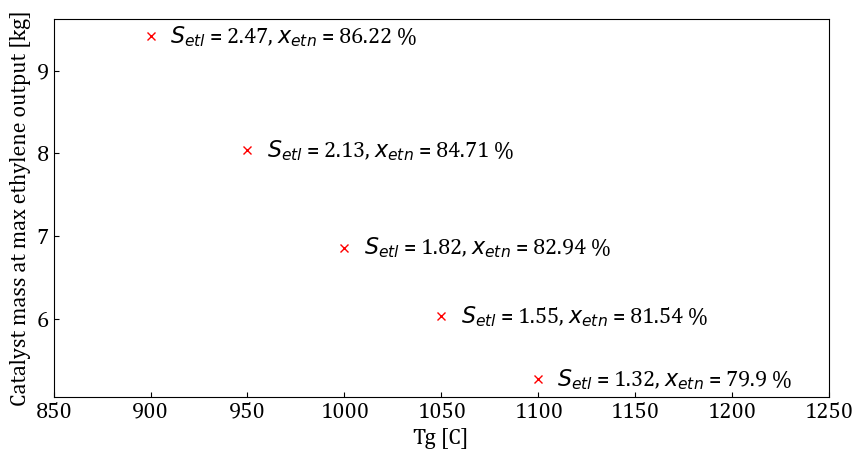

In [38]:
ws = []
S_etls = []
x_etns = []
for i in range(len(Tgs)):
    Tg = Tgs[i]
    Nt = Nts[i]
    w_end = w_ends[i]
      
    M_total_i, Dti, At_cs_total, G, F_total_i, ρi, ρbed, f_φ, α, dAcpdw, dAt_sa_total_dw, w_span, am = supporting_calcs_fn()
    F_etn, F_ace, F_dee, F_hyd, F_wat, F_but, F_etl, P, T = var = simulate_with_MT()
    
    i_end = np.where(F_etl == max(F_etl))[0][0]
    w = w_span[i_end]
    F_etn_end, F_ace_end, F_dee_end, F_hyd_end, F_wat_end, F_but_end, F_etl_end = F_etn[i_end], F_ace[i_end], F_dee[i_end], F_hyd[i_end], F_wat[i_end], F_but[i_end], F_etl[i_end]
    F_total_end = sum([F_etn_end, F_ace_end, F_dee_end, F_hyd_end, F_wat_end, F_but_end, F_etl_end])
    S_etl = F_etl_end/sum([F_ace_end, F_dee_end, F_hyd_end, F_but_end])
    x_etn = (F_etn_i - F_etn_end)/F_etn_i*100
    mhsv = M_total_i*3600/w
    print(x_etn)
    ws.append(w)
    S_etls.append(S_etl)
    x_etns.append(x_etn)
plot_Tg_opt()

In [39]:
def solve_o2_fn(o2_excess, *args):
    Tg = args[0] + 273.15
    o2 = 1 + o2_excess
    ΔH_o2 = (2*o2 - 2)*calc_molar_ΔH(Cp_constants_o2, Tg)
    ΔH_n2 = (2*o2*79/21)*calc_molar_ΔH(Cp_constants_n2, Tg)
    ΔH_co2 = (45/55 + 1)*calc_molar_ΔH(Cp_constants_co2, Tg)
    ΔH_h2o = 2*calc_molar_ΔH(Cp_constants_h2o, Tg)
    return ΔH_o2 + ΔH_n2 + ΔH_co2 + ΔH_h2o + ΔHrx_comb_ref

o2_excess = fsolve(solve_o2_fn, 10, args=(800))[0]  # 10 % excess air
o2_excess*100 # % excess

98.32962148458148

## Inlet temperature
Min temp: Dew point of ethanol/water = 84 C. At 775, hydrogen selectivity started to be significantly higher than all others, hence why ethanol conversion went up

In [40]:
# revert to base case
F_etn_i = 3.2588907*1e3/3600 # mol.s-1
F_wat_i = 0.17152056*1e3/3600 # mol.s-1
Pi = 1.3*1e5 # Pa
Tg = 1000 + 273.15 # K
Dto = 0.0603 # m
tt = 0.002 # m
st = 2*Dto # m 
Nt = 7 # tubes
Dp = 5*1e-3 # m

In [41]:
Tis = np.array([85, 315, 545, 775]) + 273.15
Nts = np.array([9, 8, 6, 6]) 
w_ends = np.array([13, 9, 6, 6])

84.79894345572437
84.56230499209781
83.99383111268746
93.10353899698308


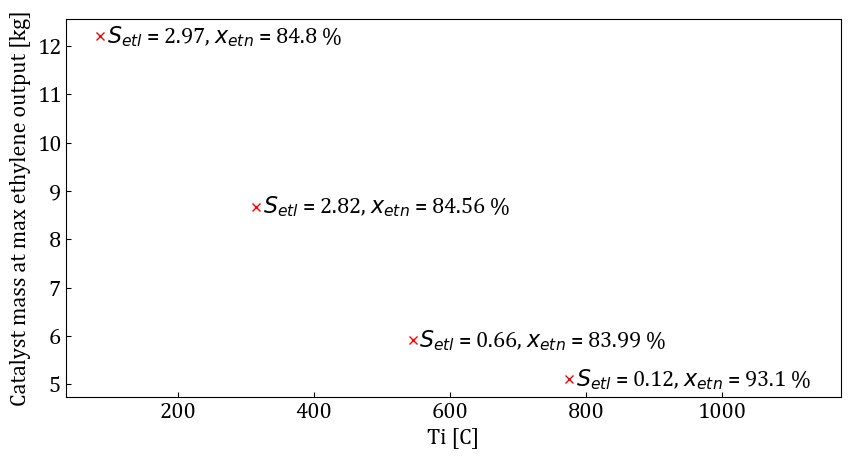

In [42]:
ws = []
S_etls = []
x_etns = []
for i in range(len(Tis)):
    Ti = Tis[i]
    Nt = Nts[i]
    w_end = w_ends[i]
      
    M_total_i, Dti, At_cs_total, G, F_total_i, ρi, ρbed, f_φ, α, dAcpdw, dAt_sa_total_dw, w_span, am = supporting_calcs_fn()
    F_etn, F_ace, F_dee, F_hyd, F_wat, F_but, F_etl, P, T = var = simulate_with_MT()
    
    i_end = np.where(F_etl == max(F_etl))[0][0]
    w = w_span[i_end]
    F_etn_end, F_ace_end, F_dee_end, F_hyd_end, F_wat_end, F_but_end, F_etl_end = F_etn[i_end], F_ace[i_end], F_dee[i_end], F_hyd[i_end], F_wat[i_end], F_but[i_end], F_etl[i_end]
    F_total_end = sum([F_etn_end, F_ace_end, F_dee_end, F_hyd_end, F_wat_end, F_but_end, F_etl_end])
    S_etl = F_etl_end/sum([F_ace_end, F_dee_end, F_hyd_end, F_but_end])
    x_etn = (F_etn_i - F_etn_end)/F_etn_i*100
    mhsv = M_total_i*3600/w
    print(x_etn)
    ws.append(w)
    S_etls.append(S_etl)
    x_etns.append(x_etn)
plot_Ti_opt()

In [43]:
# revert to base case
F_etn_i = 3.2588907*1e3/3600 # mol.s-1
F_wat_i = 0.17152056*1e3/3600 # mol.s-1
Ti = 775 + 273.15 # K
Pi = 1.3*1e5 # Pa
Tg = 1000 + 273.15 # K
Dto = 0.0603 # m
tt = 0.002 # m
st = 2*Dto # m 
Nt = 6 # tubes
Dp = 5*1e-3 # m

w_end = 6 # kg

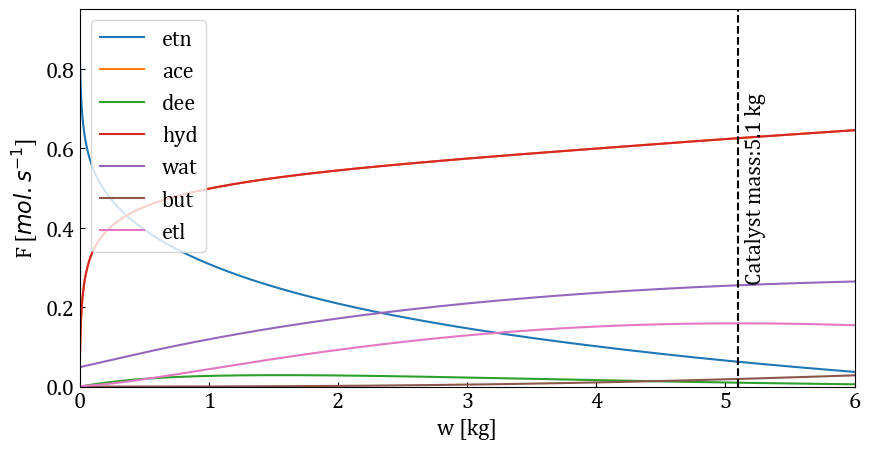

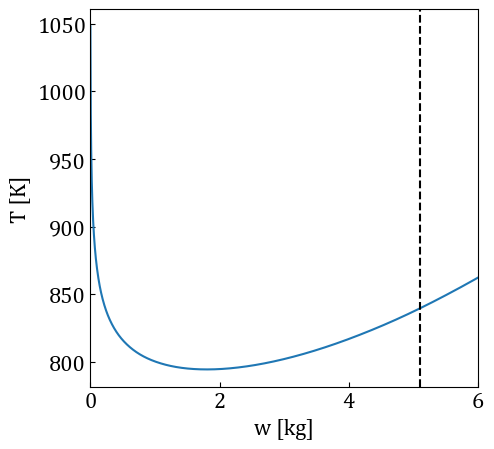

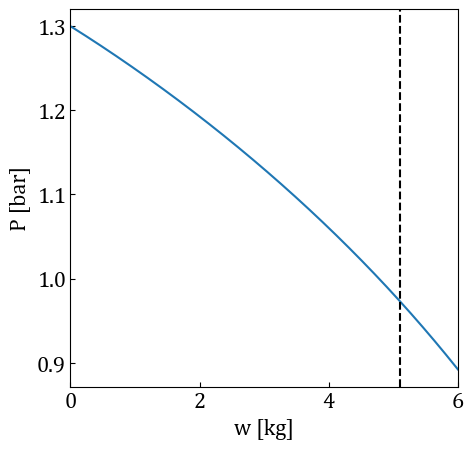

In [44]:
M_total_i, Dti, At_cs_total, G, F_total_i, ρi, ρbed, f_φ, α, dAcpdw, dAt_sa_total_dw, w_span, am = supporting_calcs_fn()
F_etn, F_ace, F_dee, F_hyd, F_wat, F_but, F_etl, P, T = var = simulate_with_MT()
i_end = np.where(F_etl == max(F_etl))[0][0]
w = w_span[i_end]


var = F_etn[200], F_ace[200], F_dee[200], F_hyd[200], F_wat[200], F_but[200], F_etl[200], P[200], T[200]
plot_FTP()

# Inlet pressure optimisation
S_etl local max at 3.1 bar (acetaldehyde and hydrogen decrease, ethylene increase), conversion increases with pressure

In [45]:
# revert to base case
F_etn_i = 3.2588907*1e3/3600 # mol.s-1
F_wat_i = 0.17152056*1e3/3600 # mol.s-1
Ti = 420 + 273.15 # K
Tg = 1000 + 273.15 # K

Dto = 0.0603 # m
tt = 0.002 # m
st = 2*Dto # m 
Nt = 6 # tubes
Dp = 5*1e-3 # m

In [46]:
Pis = np.array([1.3, 2.3, 3.3, 4.3, 5.3, 6.3, 7.3])*1e5 # Pa
Nts = np.array([7, 6, 5, 5, 5, 5, 4])
w_ends = np.array([7, 6, 5, 5, 4, 4, 4])

82.94439665874368
87.53675668174682
90.31444967815985
91.96190376840158
93.09504728503804
93.89015897381584
94.44954310895935


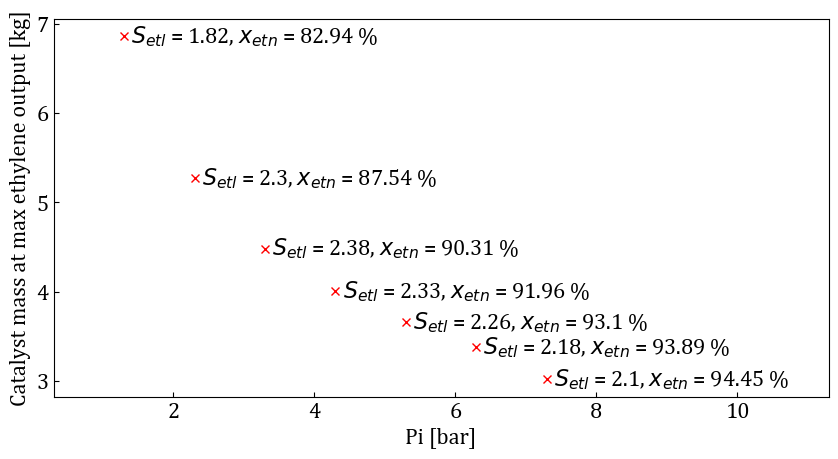

In [47]:
ws = []
S_etls = []
x_etns = []
for i in range(len(Pis)):
    Pi = Pis[i]
    Nt = Nts[i]
    w_end = w_ends[i]
      
    M_total_i, Dti, At_cs_total, G, F_total_i, ρi, ρbed, f_φ, α, dAcpdw, dAt_sa_total_dw, w_span, am = supporting_calcs_fn()
    F_etn, F_ace, F_dee, F_hyd, F_wat, F_but, F_etl, P, T = var = simulate_with_MT()
    
    i_end = np.where(F_etl == max(F_etl))[0][0]
    w = w_span[i_end]
    F_etn_end, F_ace_end, F_dee_end, F_hyd_end, F_wat_end, F_but_end, F_etl_end = F_etn[i_end], F_ace[i_end], F_dee[i_end], F_hyd[i_end], F_wat[i_end], F_but[i_end], F_etl[i_end]
    F_total_end = sum([F_etn_end, F_ace_end, F_dee_end, F_hyd_end, F_wat_end, F_but_end, F_etl_end])
    S_etl = F_etl_end/sum([F_ace_end, F_dee_end, F_hyd_end, F_but_end])
    x_etn = (F_etn_i - F_etn_end)/F_etn_i*100
    mhsv = M_total_i*3600/w
    print(x_etn)
    ws.append(w)
    S_etls.append(S_etl)
    x_etns.append(x_etn)
plot_Pi_opt()

### Tube size and number optimisation
Number of tubes calculated for each Dto such that L/D>2.

In [48]:
# revert to base case
F_etn_i = 3.2588907*1e3/3600 # mol.s-1
F_wat_i = 0.17152056*1e3/3600 # mol.s-1
Ti = 420 + 273.15 # K
Pi = 1.3*1e5 # Pa
Tg = 1000 + 273.15 # K

Dto = 0.0603 # m
tt = 0.002 # m
st = 2*Dto # m 
Nt = 6 # tubes
Dp = 5*1e-3 # m

w_end = 6 # kg

In [49]:
Dtos = np.array([48.3, 60.3, 73.0, 88.9, 101.6])*1e-3
Nts = np.array([9, 7, 6, 5, 4]) # worked out such that L/D>2
w_ends = np.array([7, 7, 9, 11, 12])

0.5993903904449497 0.2767386150481876 2.1659080368693027
0.5773411266362309 0.26871720591635606 2.148508223235771
0.540356778110436 0.27883946029700063 1.9378777219511367
0.5246141163378139 0.28297748881738993 1.8539075971387817
0.5686804815432495 0.25872227549018506 2.198034477185259


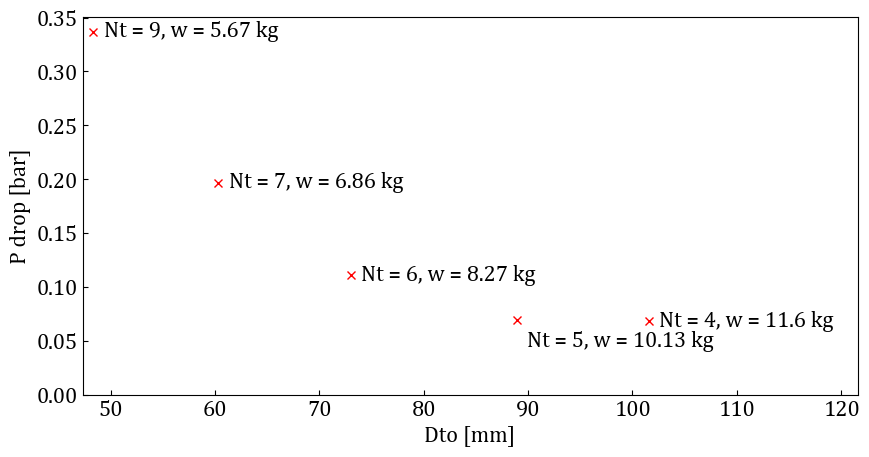

In [50]:
ws = []
S_etls = []
x_etns = []
P_drops = []
for i in range(len(Dtos)):
    Dto = Dtos[i]
    Nt = Nts[i]
    w_end = w_ends[i] 
    st = 2*Dto
    
    M_total_i, Dti, At_cs_total, G, F_total_i, ρi, ρbed, f_φ, α, dAcpdw, dAt_sa_total_dw, w_span, am = supporting_calcs_fn()
    F_etn, F_ace, F_dee, F_hyd, F_wat, F_but, F_etl, P, T = var = simulate_with_MT()
    i_end = np.where(F_etl == max(F_etl))[0][0]
    w = w_span[i_end]
    F_etn_end, F_ace_end, F_dee_end, F_hyd_end, F_wat_end, F_but_end, F_etl_end = F_etn[i_end], F_ace[i_end], F_dee[i_end], F_hyd[i_end], F_wat[i_end], F_but[i_end], F_etl[i_end]
    F_total_end = sum([F_etn_end, F_ace_end, F_dee_end, F_hyd_end, F_wat_end, F_but_end, F_etl_end])
    P_end = P[i_end]
    P_drop = 1.3 - P_end*1e-5 # bar
    S_etl = F_etl_end/sum([F_ace_end, F_dee_end, F_hyd_end, F_but_end])
    x_etn = (F_etn_i - F_etn_end)/F_etn_i*100
    mhsv = M_total_i*3600/w
    L, D_bundle, L_over_D_bundle = calc_dimensions_fn()
    print(L, D_bundle, L_over_D_bundle)
    ws.append(w)
    S_etls.append(S_etl)
    x_etns.append(x_etn)    
    P_drops.append(P_drop)
plot_P_drop()

# Particle diameter effects
below 3mm, pressure drop very severe---ethylene max didnt occur

In [51]:
# revert to base case
F_etn_i = 3.2588907*1e3/3600 # mol.s-1
F_wat_i = 0.17152056*1e3/3600 # mol.s-1
Ti = 420 + 273.15 # K
Pi = 1.3*1e5 # Pa
Tg = 1000 + 273.15 # K
Dto = 0.0603 # m
tt = 0.002 # m
st = 2*Dto # m 
Nt = 7 # tubes

w_end = 10# kg

In [52]:
Dps = np.array([3, 4, 5, 6, 7, 8])*1e-3 # m 
Nts = np.array([7, 7, 7, 7, 7, 7]) # worked out such that L/D>2
w_ends = np.array([8, 7, 7, 7, 8, 8])

<ipython-input-13-8909204c3406>:165: RuntimeWarning: invalid value encountered in double_scalars
  mears = r*ρbed*(Dp/2)*n/(kc*C)
<ipython-input-13-8909204c3406>:166: RuntimeWarning: invalid value encountered in double_scalars
  Cwp = r*ρcat*(Dp/2)**2/(De*C)


89.14503859745034
86.57068888859388
82.94439665874368
79.29238366432693
76.7625032879211
75.38120286559425


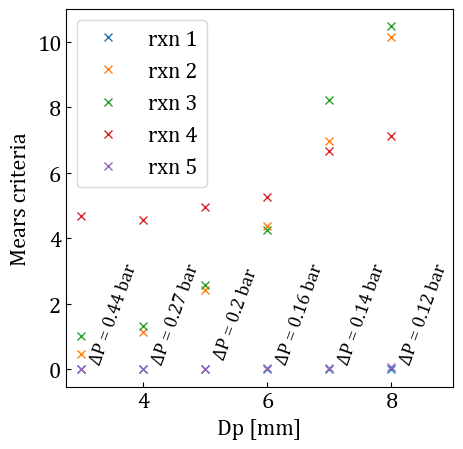

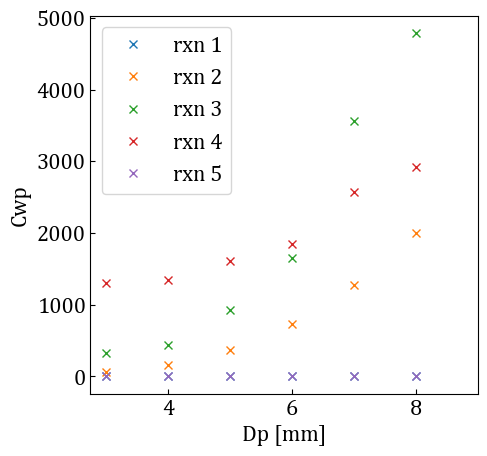

In [53]:
ws = []
S_etls = []
x_etns = []
P_drops = []
mears_avgs_1, mears_avgs_2, mears_avgs_3, mears_avgs_4, mears_avgs_5 = [], [], [], [], []
Cwp_avgs_1, Cwp_avgs_2, Cwp_avgs_3, Cwp_avgs_4, Cwp_avgs_5 = [], [], [], [], []
for i in range(len(Dps)):
    Dp = Dps[i]
    Nt = Nts[i]
    w_end = w_ends[i]
    
    M_total_i, Dti, At_cs_total, G, F_total_i, ρi, ρbed, f_φ, α, dAcpdw, dAt_sa_total_dw, w_span, am = supporting_calcs_fn()
    F_etn, F_ace, F_dee, F_hyd, F_wat, F_but, F_etl, P, T = var = simulate_with_MT()
    mears_1, Cwp_1, mears_2, Cwp_2, mears_3, Cwp_3, mears_4, Cwp_4, mears_5, Cwp_5  = pbr_mt_var_fn(var)
    mears_avg_1, mears_avg_2, mears_avg_3, mears_avg_4, mears_avg_5 = np.nanmean(mears_1), np.nanmean(mears_2), np.nanmean(mears_3), np.nanmean(mears_4), np.nanmean(mears_5)
    Cwp_avg_1, Cwp_avg_2, Cwp_avg_3, Cwp_avg_4, Cwp_avg_5 = np.nanmean(Cwp_1), np.nanmean(Cwp_2), np.nanmean(Cwp_3), np.nanmean(Cwp_4), np.nanmean(Cwp_5)
    
    i_end = np.where(F_etl == max(F_etl))[0][0]
    w = w_span[i_end]
    F_etn_end, F_ace_end, F_dee_end, F_hyd_end, F_wat_end, F_but_end, F_etl_end = F_etn[i_end], F_ace[i_end], F_dee[i_end], F_hyd[i_end], F_wat[i_end], F_but[i_end], F_etl[i_end]
    F_total_end = sum([F_etn_end, F_ace_end, F_dee_end, F_hyd_end, F_wat_end, F_but_end, F_etl_end])
    P_end = P[i_end]
    P_drop = 1.3 - P_end*1e-5 # bar
    S_etl = F_etl_end/sum([F_ace_end, F_dee_end, F_hyd_end, F_but_end])
    x_etn = (F_etn_i - F_etn_end)/F_etn_i*100
    mhsv = M_total_i*3600/w
    print(x_etn)
    ws.append(w)
    S_etls.append(S_etl)
    x_etns.append(x_etn)    
    P_drops.append(P_drop)
    
    mears_avgs_1.append(mears_avg_1)
    mears_avgs_2.append(mears_avg_2)
    mears_avgs_3.append(mears_avg_3)
    mears_avgs_4.append(mears_avg_4)
    mears_avgs_5.append(mears_avg_5)
    Cwp_avgs_1.append(Cwp_avg_1)
    Cwp_avgs_2.append(Cwp_avg_2)
    Cwp_avgs_3.append(Cwp_avg_3)
    Cwp_avgs_4.append(Cwp_avg_4)
    Cwp_avgs_5.append(Cwp_avg_5)
plot_Dp_opt_mears()
plot_Dp_opt_Cwp()

# Final design
base case: S_etl: 1.824277582649703,  x_etn: 82.93994786258556, mhsv 22.34046818324902


In [54]:
# revert to base case
F_etn_i = 3.2588907*1e3/3600 # mol.s-1
F_wat_i = 0.17152056*1e3/3600 # mol.s-1
Ti = 85 + 273.15 # K
Pi = 1.5*1e5 # Pa
Tg = 800 + 273.15 # K
Dto = 0.073 # m
tt = 0.00211 # m
st = 2*Dto # m 
Nt = 11 # tubes
Dp = 2*1e-3 # m

w_end = 31# kg

L:1.0706920610484942, D_bundle: 0.5112056772111678, L_over_D_bundle: 2.0944447778623063
F_etl: 0.721276047786687, S_etl: 10.444034885135643, x_etn: 93.77425331799301, mhsv: 5.135266226147543, ΔP: 0.19742353457962733


<ipython-input-13-8909204c3406>:165: RuntimeWarning: invalid value encountered in double_scalars
  mears = r*ρbed*(Dp/2)*n/(kc*C)
<ipython-input-13-8909204c3406>:166: RuntimeWarning: invalid value encountered in double_scalars
  Cwp = r*ρcat*(Dp/2)**2/(De*C)


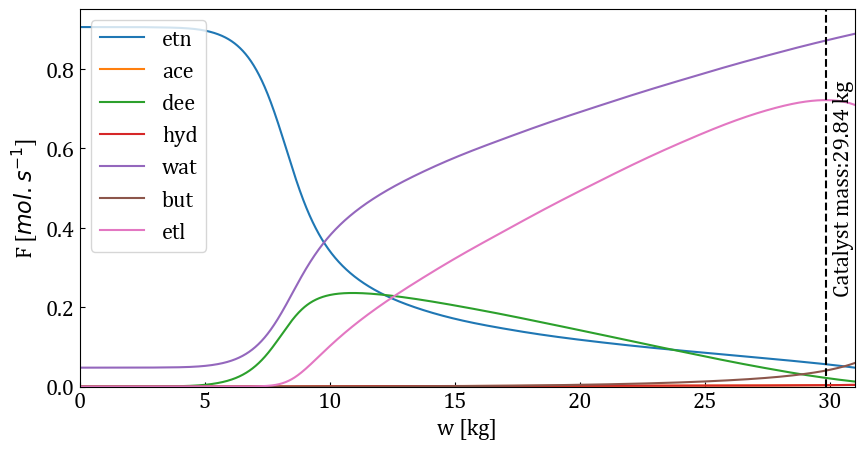

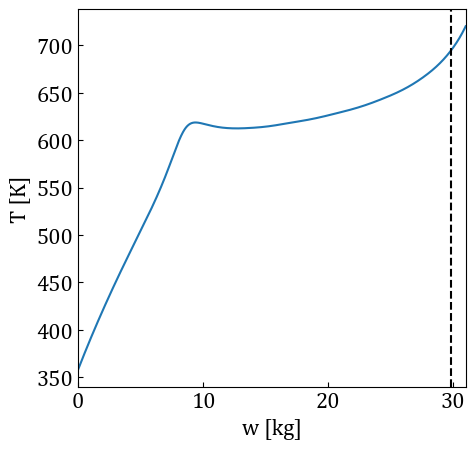

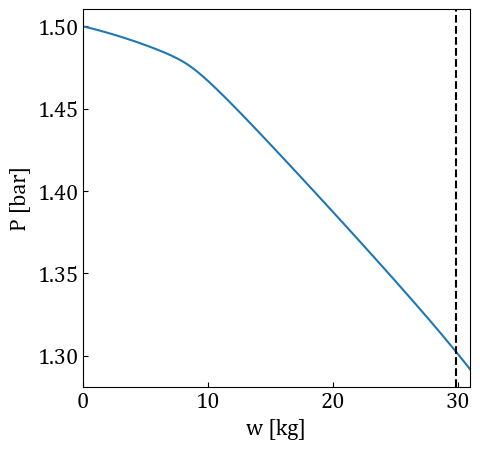

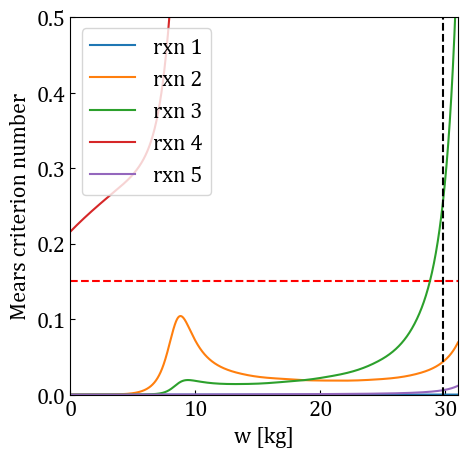

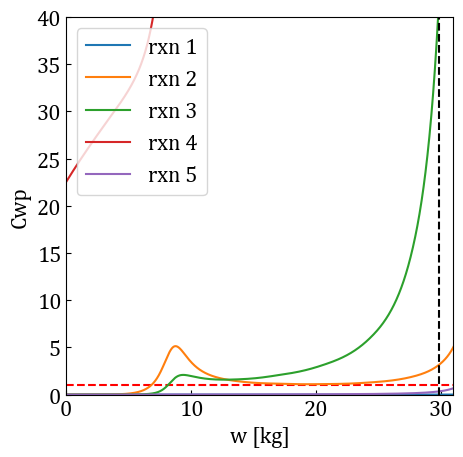

In [55]:
M_total_i, Dti, At_cs_total, G, F_total_i, ρi, ρbed, f_φ, α, dAcpdw, dAt_sa_total_dw, w_span, am = supporting_calcs_fn()
F_etn, F_ace, F_dee, F_hyd, F_wat, F_but, F_etl, P, T = var = simulate_with_MT()
i_end = np.where(F_etl == max(F_etl))[0][0]
w = w_span[i_end]

F_etn_end, F_ace_end, F_dee_end, F_hyd_end, F_wat_end, F_but_end, F_etl_end = F_etn[i_end], F_ace[i_end], F_dee[i_end], F_hyd[i_end], F_wat[i_end], F_but[i_end], F_etl[i_end]
F_total_end = sum([F_etn_end, F_ace_end, F_dee_end, F_hyd_end, F_wat_end, F_but_end, F_etl_end])
S_etl = F_etl_end/sum([F_ace_end, F_dee_end, F_hyd_end, F_but_end])
x_etn = (F_etn_i - F_etn_end)/F_etn_i*100
mhsv = M_total_i*3600/w
L, D_bundle, L_over_D_bundle = calc_dimensions_fn()
P_end = P[i_end]
P_drop = (Pi - P_end)*1e-5 # bar
print(f'L:{L}, D_bundle: {D_bundle}, L_over_D_bundle: {L_over_D_bundle}')
print(f'F_etl: {F_etl[i_end]}, S_etl: {S_etl}, x_etn: {x_etn}, mhsv: {mhsv}, ΔP: {P_drop}')
plot_FTP()
mears_1, Cwp_1, mears_2, Cwp_2, mears_3, Cwp_3, mears_4, Cwp_4, mears_5, Cwp_5  = pbr_mt_var_fn(var)
plot_MT()

In [56]:
η2 = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.9579767396158512,0.957141022889155,0.9556247666330744,0.9555514249561625,0.9369986410377639,0.9134463840005923,0.6618261616328609,0.4938843192559085,0.2413250714478913,1,0.9531789212576679,0.9513656649277987,0.9344597713378618,0.9298861458924955,0.9233341538940435,0.9232521717374648,0.9093648839666992,0.9010676705694676,0.8494932799293775,0.8384164090360711,0.8240758860785674,0.8244881810068578,0.7875981435466527,0.7692014290792368,0.6964062785241668,0.6923098935276583,0.6867766283116334,0.6815081480098039,0.673084435205009,0.6879412194809661,0.6479263393647131,0.46614620871405077,0.4298334613782585,0.7273929288603107,0.676368436685366,0.6798379326654311,0.684258317256967,0.6633500784741744,0.6696987522290376,0.7058883449184041,0.7170826432720572,0.723322800250507,0.7453589921011392,0.7355033262355678,0.7395694259604807,0.7615714260756528,0.7759105185746095,0.7814512325249928,0.8067528864940657,0.8079048456293695,0.8111523331743757,0.8160551032085218,0.828061351498122,0.8316576414826935,0.8535626593455719,0.8634537992510246,0.8663042248253527,0.8557304336201214,0.8658501548117052,0.8673908131774597,0.8899174535144591,0.9153264641812905,0.9198742859706301,0.8806698362929907,0.8833173504711829,0.883245095138711,0.8895136735290337,0.9019437592038813,0.9042883529012107,0.8832174854745309,0.8825008434285987,0.880772812698988,0.8791301845840807,0.8928907201567183,0.8935409864205526,0.8669658253788194,0.8613979333086852,0.8559893384049839,0.8395421369359264,0.8640664678871631,0.8594642322363726,0.80640955170249,0.8621234221789473,0.8577981230009394,0.8425557634812517,0.8564850748499984,0.8520835391623479,0.8203473876861715,0.8062269660229705,0.7944278550474762,0.7409365150049675,0.7649503462123427,0.7478162256343057,0.6780186321810991,0.8102178182468118,0.8028852774815032,0.7672336225246152,0.7700564574910441,0.7589258275207618,0.7399081278513066,0.7302694493784325,0.7244929630098351,0.6946061754416588,0.6894854412942283,0.6816093344033191,0.680129449605411]
print(np.mean(η2))

0.8255975888801796


In [57]:
η3 = [0.9999999809827645,1.0000000015374673,0.9999999960931397,0.9999999721625996,0.9999999714765199,1.0000000207937074,1.0000000019457873,0.9999999719743485,0.9999999943111397,0.9999999884031525,0.9999997509652684,0.9999995777219371,0.9999992275655167,0.9999992517096947,0.9999957558796969,0.9999910438363923,0.9997450403989926,0.9995733662912706,0.999204585295478,0.999178398449839,0.9975048477832624,0.995379648489789,0.9042640204620591,0.6892622599275995,0.25033415990505364,0.9999989941615433,0.9988915488498179,0.9987090734132819,0.9972624294005673,0.9968731514942382,0.9962974533373858,0.9962888778194504,0.9949829867468358,0.9941189775881051,0.9871544902554006,0.9851865551920176,0.9823406610590423,0.9824354360173637,0.9733129631549235,0.9671335506239661,0.925450323424805,0.9191326596099357,0.9099545022257409,0.9071576126382438,0.886016844923952,0.889614503643434,0.8351360199255595,0.6665368929521556,0.6339902992572821,0.8777006132930674,0.8954834995513367,0.8937725277743063,0.8778278975388355,0.8632336907902336,0.8643375082584602,0.8839270545033238,0.884504192303117,0.8861083851675599,0.8867017559668889,0.8756766870401117,0.875954243448129,0.8938094657886865,0.8971162116630342,0.8985149015060807,0.9022315372520759,0.8981026775036794,0.897931574624183,0.9055782763971797,0.9075811277069065,0.9076461063148448,0.9093126767302078,0.9118284465167216,0.9114177478779336,0.9073735719910734,0.905562975619316,0.9028753873198372,0.898593092066085,0.9157425582780864,0.9174484937615356,0.8827696337196819,0.8761218766162144,0.8714308908898758,0.8535552646662254,0.8658451899433407,0.8641296765901451,0.8338054608191209,0.8199140747381803,0.8106146906236593,0.7708122973147199,0.7890943107617978,0.7817410576785971,0.7319914023042912,0.7033239263846286,0.683252421000699,0.5965501182564059,0.6304338913606878,0.6052184474556779,0.515470951250134,0.7071849052628862,0.6906002002362073,0.6151673726465973,0.6313387089795036,0.6103022400418513,0.5552556919770386,0.5118888013567442,0.48244819811861434,0.3536028913745238,0.36491595308928415,0.328443244944804,0.2706791241913729,0.5240106466777021,0.5045180774794651,0.4132326167491003,0.4080594747116192,0.38422890350049976,0.3640195321632935,0.34684955595797784,0.33729127044430085,0.29139986478383656,0.28361264517096557,0.27311291662376647,0.2721990898890144]
print(np.mean(η3))

0.8042847543883231
